In [1]:
import time
import torch
import pickle
import os
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from utils import tools, callbacks, metrics, supported_preprocessing_transforms
from modules.cae_base_module import CAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from datasets import supported_datamodules
from models import supported_models
from functools import reduce

# Novel Region Extraction with Generic Reconstructions

Images of planetary landscapes contain incredible amounts of valuable information. This poses a problem for novelty detection. Since truly novel content may only take up a small fraction of the image, global image properties that may be useful for novelty detection are diluated by the other details in the landscape. This experiment seeks to address this limitation by implementing *novel region extraction*, the task of tagging regions in larger images and ranking them by novelty. We hypothesize that by using unsupervised object recognition to intelligently cropped regions, general reconstruction-based detection techniques can be repurposed into novel region extractors.

From a practical perspective, the region proposal step is implemented within the preprocessing pipeline. In the following code, the region proposal itself is called implicitly in the `supported_preprocessing_transforms`, the code for it is found in `utils/preprocessing.py`. Given the large computational burden placed on the CPU when region extraction  is used during preprocessing, it is easier to load the batch once and test each model serially than to test the models with their own dedicted dataloaders. One downside is that the batch size is static for all testing cycles; however, since batches are looped over in the `test_step` regardless of the model, this only affects the amount of data dropped in the final batch when the test size isn't divisible by the batch size.

In [2]:
# Import configurations and paths to logged models
root = Path.cwd() / '..'
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_nre*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
SimpleVAE/archive_nre1_2021-05-04
SimpleVAE/archive_nre2_2021-05-04
SimpleAAE/archive_nre2_2021-05-03
SimpleAAE/archive_nre1_2021-05-03
BaselineCAE/archive_nre1_2021-05-02
CompressionCAEHighCapacity/archive_nre1_2021-05-03
CompressionCAEMidCapacity/archive_nre1_2021-05-02


In [3]:
# Load the checkpoints for all the training modules and save them in a dictionary
module_catalog = {}

for pth in paths_to_archived_models:
    config = tools.load_config(pth / 'configuration.yaml', silent=True)
    model_type = pth.parent.name
    model_name = pth.name
    ckpt_path = next(iter((pth / 'checkpoints').glob('val_*')))
    
    # Unsupervising region proposal is called implicity in this line, see utils/preprocessing.py
    preprocessing_transforms = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]
    
    datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
        data_transforms=preprocessing_transforms,
        **config['data-parameters'])
    datamodule.setup('test')

    # Handle the various model instantiations
    if 'AAE' in model_type:
        model = supported_models[model_type](
            in_nodes=reduce(lambda x, y: x*y, datamodule.data_shape),
            latent_nodes=config['module-parameters']['latent_nodes'])
        module = AAEBaseModule(model, **config['module-parameters'])
    elif 'VAE' in model_type:
        model = supported_models[model_type](
            in_shape=datamodule.data_shape,
            latent_nodes=config['module-parameters']['latent_nodes'])
        module = VAEBaseModule(model, **config['module-parameters'])
    elif 'CAE' in model_type:
        model = supported_models[model_type](in_shape=datamodule.data_shape)
        module = CAEBaseModule(model, **config['module-parameters'])
    else:
        raise ValueError(f'Model substring not found, got {model_type}')
        
    # Load the state_dict into the module architecture
    checkpoint = torch.load(ckpt_path)
    module.load_state_dict(checkpoint['state_dict'])
    
    if model_type not in module_catalog:
        module_catalog[model_type] = {}
    module_catalog[model_type][model_name] = module
    print(f'Loaded state dict for: {model_type}/{model_name}')

Loaded state dict for: SimpleVAE/archive_nre1_2021-05-04
Loaded state dict for: SimpleVAE/archive_nre2_2021-05-04
Loaded state dict for: SimpleAAE/archive_nre2_2021-05-03
Loaded state dict for: SimpleAAE/archive_nre1_2021-05-03
Loaded state dict for: BaselineCAE/archive_nre1_2021-05-02
Loaded state dict for: CompressionCAEHighCapacity/archive_nre1_2021-05-03
Loaded state dict for: CompressionCAEMidCapacity/archive_nre1_2021-05-02


In [25]:
# Testing loop
# Caution: this loop takes _minutes_ to run.
start = time.time()

# Collect scores and labels for all models in a catalog
result_catalog = {}

# Loop over the test dataloader, using the same batch for each model to save time
with torch.no_grad():
    for batch_nb, batch in enumerate(datamodule.test_dataloader()):
        print(f'------\nLoaded batch {batch_nb}\n------')
                
        # Extract the model type (e.g. CAE, AAE, VAE) and their versions
        for model_type, model_versions in module_catalog.items():
            
            # Extract the name of the archive and the module's state dict
            for model_name, module in model_versions.items():
                
                # Set the model/components in evaluation mode
                if 'AAE' in model_type:
                    module.encoder.eval()
                    module.decoder.eval()
                else:
                    module.model.eval()
                
                short_name = model_type + '-' + model_name.split('_')[1]
                if short_name not in result_catalog:
                    result_catalog[short_name] = {
                        'scores': [], 
                        'filepaths': [],
                        'gt_bboxes': [],
                        'cr_bboxes': []
                    }
                print(f'Testing on: {short_name}')

                result = module.test_step(batch, batch_nb)
                
                result_catalog[short_name]['scores'].extend(result['scores'])
                result_catalog[short_name]['filepaths'].extend(result['labels']['filepaths'])
                result_catalog[short_name]['gt_bboxes'].extend(result['labels']['gt_bboxes'])
                result_catalog[short_name]['cr_bboxes'].extend(result['labels']['cr_bboxes'])
                
print(f'Training took: {time.time() - start:.2f}')

------
Loaded batch 0
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: SimpleAAE-nre2
Testing on: SimpleAAE-nre1
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
------
Loaded batch 1
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: SimpleAAE-nre2
Testing on: SimpleAAE-nre1
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
------
Loaded batch 2
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: SimpleAAE-nre2
Testing on: SimpleAAE-nre1
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
------
Loaded batch 3
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: SimpleAAE-nre2
Testing on: SimpleAAE-nre1
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCa

In [26]:
# Format data for plotting and analysis
for sn, results in result_catalog.items():
    results['scores'] = np.array(results['scores'])
    results['filepaths'] = np.array(results['filepaths']).reshape(-1)
    results['gt_bboxes'] = np.array(results['gt_bboxes']).reshape(-1, 4)
    results['cr_bboxes'] = np.array(results['cr_bboxes']).reshape(-1, 4)

with open('nre-results_2021-05-05.pkl', 'wb') as f:
    pickle.dump(result_catalog, f)

In [48]:
ious = []
# binary_labels = []  # IOU > 0.5 counts as a label
n_duplicates = 0
n_novelties = 428

gt_bboxes = result_catalog['BaselineCAE-nre1']['gt_bboxes']
cr_bboxes = result_catalog['BaselineCAE-nre1']['cr_bboxes']
for i, (gt, cr) in enumerate(zip(gt_bboxes, cr_bboxes)):
    cr = cr * 5  # Rescale the bounding boxes, see 'scale' parameter in LunarAnaloguePreprocesing
    iou = metrics.iou(cr, gt)
    ious.append(iou)
    
    if i == 0:
        prev_gt = [-1, -1, -1, -1]
    if iou > 0.6:
        if all(gt == prev_gt):
            n_duplicates += 1
        prev_gt = gt
    
ious = np.array(ious)
bin_labels = ious > 0.6

print(f'Number of novelties: {n_novelties}')
print(f'Number of overlapping bounding boxes: {sum(bin_labels)}')
print(f'Number of duplicate detections: {n_duplicates}')

Number of novelties: 428
Number of overlapping bounding boxes: 96
Number of duplicate detections: 5


It is important to note a large assumtion that

SimpleVAE-nre1: 933.5975801583845
SimpleVAE-nre2: 810.0836985252681
SimpleAAE-nre2: 732.6461637118482
SimpleAAE-nre1: 762.7082133439835
BaselineCAE-nre1: 124.18814054998802
CompressionCAEHighCapacity-nre1: 147.882209488831
CompressionCAEMidCapacity-nre1: 138.10496414213776


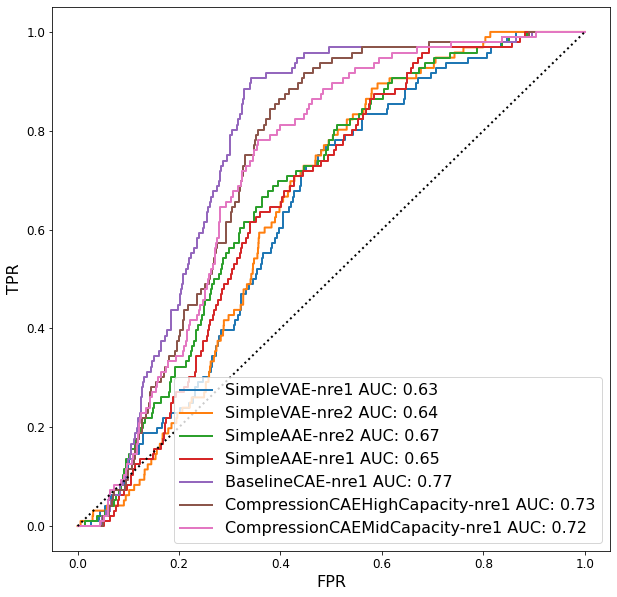

Random ROC AUC: 0.5


In [31]:
plt.figure(figsize=(10,10))
for sn, results in result_catalog.items():

    scores = results['scores']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, bin_labels)
    
    plt.plot(fpr, tpr, lw=2., label=f'{sn} AUC: {auc:.2f}')
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.legend(fontsize=16)
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.show()
print('Random ROC AUC: 0.5')

In [9]:
config = tools.load_config('../logs/LunarAnalogueDataModule/BaselineCAE/archive_nre1_2021-05-02/configuration.yaml')

ptransf = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

dm = supported_datamodules[config['experiment-parameters']['datamodule']](
    data_transforms=ptransf,
    **config['data-parameters'])
dm.setup('test')

model = supported_models[config['experiment-parameters']['model']](dm.data_shape)

module = CAEBaseModule(model, **config['module-parameters'])

# Load the state_dict into the module architecture
checkpoint = torch.load('../logs/LunarAnalogueDataModule/BaselineCAE/archive_nre1_2021-05-02/checkpoints/val_loss=0.01-epoch=7.ckpt')
module.load_state_dict(checkpoint['state_dict'])

Experimental parameters
------
{'data-parameters': {'batch_size': 32,
                     'glob_pattern_test': None,
                     'glob_pattern_train': None,
                     'preprocessing': 'LunarAnalogueRegionExtractor',
                     'root_data_path': '/home/brahste/Datasets/NoveltyLunarAnalogue',
                     'train_fraction': None,
                     'use_nre_collation': True},
 'experiment-parameters': {'datamodule': 'LunarAnalogueDataModule',
                           'log_dir': 'logs',
                           'model': 'BaselineCAE',
                           'patience': None},
 'module-parameters': {'learning_rate': 0.0009120108393559097,
                       'weight_decay_coefficient': 0.1}}


<All keys matched successfully>

In [10]:
# Collect scores and labels for all models into a catalog

test_novelty_scores = []
test_novelty_labels = []

module.model.eval()  # Freeze dropout and batch normalization parameters

with torch.no_grad():
    for batch_nb, batch in enumerate(dm.test_dataloader()):

        # Need to implement custom testing to manage regions
        batch_in, batch_labels = module.handle_batch_shape(batch)
        batch_lt = module.model.encoder(batch_in)
        batch_rc = module.model.decoder(batch_lt)
        loss = module.loss_function(batch_rc, batch_in)
        
        for x_rc, x_in in zip(batch_rc, batch_in):
            test_novelty_scores.append(module.loss_function(x_rc, x_in))

        test_novelty_labels.append(batch_labels)
        print(f'[BATCH {batch_nb}] Mean score: {loss.mean()}')

[BATCH 0] Mean score: 0.008120947517454624
[BATCH 1] Mean score: 0.007450256962329149
[BATCH 2] Mean score: 0.007954009808599949
[BATCH 3] Mean score: 0.007497146259993315
[BATCH 4] Mean score: 0.007779946085065603
[BATCH 5] Mean score: 0.008597356267273426
[BATCH 6] Mean score: 0.007438408210873604
[BATCH 7] Mean score: 0.00830748025327921
[BATCH 8] Mean score: 0.010234220884740353
[BATCH 9] Mean score: 0.010339700616896152
[BATCH 10] Mean score: 0.009757225401699543
[BATCH 11] Mean score: 0.009527400135993958
[BATCH 12] Mean score: 0.009031212888658047
[BATCH 13] Mean score: 0.009699593298137188
[BATCH 14] Mean score: 0.009073089808225632
[BATCH 15] Mean score: 0.009594758041203022
[BATCH 16] Mean score: 0.009209606796503067
[BATCH 17] Mean score: 0.009363062679767609
[BATCH 18] Mean score: 0.009065676480531693
[BATCH 19] Mean score: 0.00930169876664877
[BATCH 20] Mean score: 0.009909684769809246
[BATCH 21] Mean score: 0.009713936597108841
[BATCH 22] Mean score: 0.009145484305918217


In [11]:
# Here we extract the labels to match the number of crops obtained
scores = np.array(test_novelty_scores)
labels = np.array(test_novelty_labels)
print(scores.shape)
print(labels.shape)

gt_bboxes = []
cr_bboxes = []

for batch_labels in test_novelty_labels:
    gtbb = batch_labels['gt_bboxes'].reshape(-1, 4)
    crbb = batch_labels['cr_bboxes'].reshape(-1, 4)
    gt_bboxes.extend(gtbb)
    cr_bboxes.extend(crbb)
    
gt_bboxes = np.array(gt_bboxes)
cr_bboxes = np.array(cr_bboxes)

(13312,)
(26,)


In [12]:
print(gt_bboxes.shape)
print(cr_bboxes.shape)
ious = []
binary_labels = []  # IOU > 0.5 counts as a label

n_dups = 0

for i, (gt, cr) in enumerate(zip(gt_bboxes, cr_bboxes)):
    
    cr = cr * 5
    iou = metrics.iou(cr, gt)
    ious.append(iou)
    
    if iou > 0.6:
        binary_labels.append(1)
#         if i != 0:
#             if all(gt == prev_gt):
#                 n_dups += 1
#         prev_gt = gt
    else:
        binary_labels.append(0)
    
    
ious = np.array(ious)
binary_labels = np.array(binary_labels)
print(ious.shape)
print(binary_labels.shape)
print(sum(binary_labels))
print(n_dups)

(13312, 4)
(13312, 4)
(13312,)
(13312,)
96
0


In [13]:
print(sum(scores))

119.55092173727462


In [14]:
fpr, tpr, thresholds, auc = metrics.roc(scores, binary_labels)

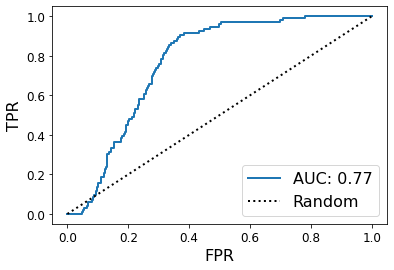

Random ROC AUC: 0.5


In [15]:
plt.plot(fpr, tpr, lw=2., label=f'AUC: {auc:.2f}')
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.show()
print('Random ROC AUC: 0.5')

In [19]:

pak = metrics.precision_at_k(scores, binary_labels)

uniques, counts = np.unique(binary_labels, return_counts=True)
random = counts.min() / counts.sum()

plt.plot(pak)
    
plt.plot([0, len(pak)], [random, random], 'k:', label='Random')
# plt.ylim([0., 1.])
plt.legend()
plt.show()

2021-05-05 18:06:25,446 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


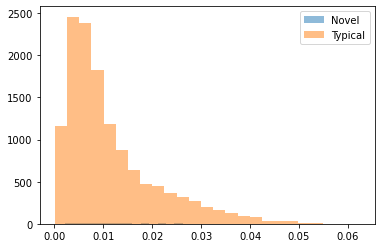

In [21]:
%matplotlib inline
typical_scores = scores[[not bool(b) for b in binary_labels]]

novel_scores = scores[[bool(b) for b in binary_labels]]

# plt.hist(scores, bins=25)
plt.hist(novel_scores, bins=25, label='Novel', alpha=0.5)
plt.hist(typical_scores, bins=25, label='Typical', alpha=0.5)

plt.legend()
plt.show()